# Tensorflow Probability Experiments

In [1]:
begin
    using Flux
    include("./Datasets.jl")
    using .Datasets
    using Plots
    using Distributions
end

In [2]:
begin
    # Contains lambda function to generate distribution.
    struct DistributionLambda
        distributionLambda::Function
    end

    # Function call to set the Gaussian distribution.
    (m::DistributionLambda)(x) = m.distributionLambda(x)

    function neglossfunc(dists, x)
        sumlogpdf = 0
        for i in range(1, length(x))
            sumlogpdf += -logpdf(dists[i], x[i])
        end
        return sumlogpdf
    end

    function create_nonlinear_model()
        model = Chain(
            Dense(1 => 2, σ),
            Dense(2 => 2),
            DistributionLambda((t)->Normal(t[1], 1e-3 + softplus(0.05 * t[2])))
        )
        return model
    end
    
    function create_case2_model()
        model = Chain(
            Dense(1 => 2),
            DistributionLambda((t)->Normal(t[1], 1e-3 + softplus(0.05 * t[2])))
        )
        return model
    end
    
    function create_case1_model()
        model = Chain(
            Dense(1 => 1),
            DistributionLambda((t)->Normal(t[1], 1))
        )
        return model
    end

    function train_step(model, train_loader)
        #Negative Log Likelihood function for the loss.
        negloglik = (dist, x) -> -logpdf(dist, x[1])
        opt = ADAM(0.01)
        ps = Flux.params(model)
        loss = 0
        for (x, y) in train_loader
            ŷ = model(x)
            loss += negloglik(model(x), y)
            gr = Flux.gradient(ps) do
                negloglik(model(x), y)
            end
            Flux.Optimise.update!(opt, ps, gr)
        end
        return loss
    end

    function get_distributions(model, test_loader)
        return [model(x) for x in test_loader]
    end

    # Cauchy needs to use location()
    function get_means(gaussians)
        return [mean(gaussian) for gaussian in gaussians]
    end

    # Cauchy needs to use scale()
    function get_stddevs(gaussians)
        return [std(gaussian) for gaussian in gaussians]
    end
    
    function get_bernoulli_ps(bernoullis)
        return [bern.p for bern in bernoullis]
    end
    
    function sample_dists(dists)
        return [rand(dist) for dist in dists]
    end
    
    function train_model(model, train_loader, test_loader, epochs)
        losses = zeros(epochs)
        means = Array{Float64}[]
        stddevs = Array{Float64}[]
        for iter in 1:epochs
            losses[iter] = train_step(model, train_loader)
            distributions = get_distributions(model, test_loader)
            push!(means, get_means(distributions))
            push!(stddevs, get_stddevs(distributions))
        end
        return losses, means, stddevs
    end
end

train_model (generic function with 1 method)

In [3]:
# Create DataLoaders
y_train, x_train, x_tst = build_dataset_tfp();
train_loader = Flux.DataLoader((x_train, y_train), batchsize=1);
test_loader = Flux.DataLoader((x_tst), batchsize=1);

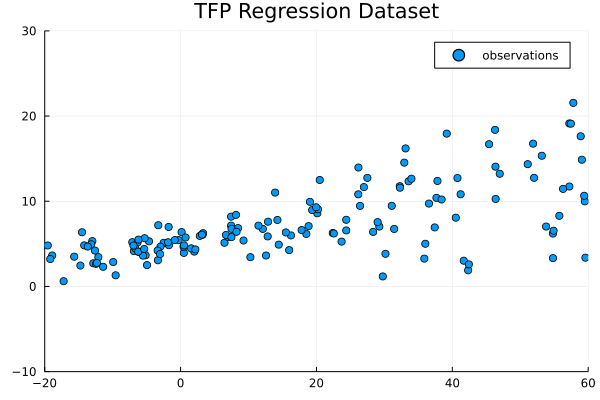

In [4]:
tfp_dataset = scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30), title="TFP Regression Dataset")
savefig(tfp_dataset,"images/tfp_dataset.png")
current()

In [5]:
model = create_case1_model()
epochs = 100
losses, means, stddevs = train_model(model, train_loader, test_loader, epochs)
anim = @animate for iter in 1:epochs
    mean = means[iter]
    stddev = stddevs[iter]
    scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30))
    plot!(x_tst, mean, label="mean", linewidth=5, linecolor=:red, xlim=(-20,60), ylim=(-10, 30), title="Iteration: "*string(iter)*"/$epochs - No Uncertainty")
end

Animation("C:\\Users\\andre\\AppData\\Local\\Temp\\jl_3vvBxu", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
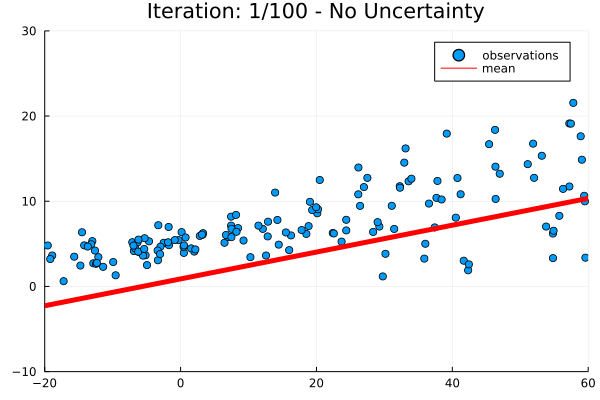

In [6]:
gif(anim, fps=15)

In [7]:
# Save Figures
for iter in [1,2,3,100]
    mean = means[iter]
    stddev = stddevs[iter]
    fig = scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30))
    plot!(x_tst, mean, label="mean", linewidth=5, linecolor=:red, xlim=(-20,60), ylim=(-10, 30), title="Iteration: "*string(iter)*"/$epochs - No Uncertainty")
    savefig(fig, "images/case_1_frame_$iter.png")
end

In [8]:
model = create_case2_model()
epochs = 100
losses, means, stddevs = train_model(model, train_loader, test_loader, epochs)
anim2 = @animate for iter in 1:epochs
    mean = means[iter]
    stddev = stddevs[iter]
    scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30))
    plot!(x_tst, mean, label="mean", linewidth=5, linecolor=:red, xlim=(-20,60), ylim=(-10, 30), title="Iteration: "*string(iter)*"/$epochs - Aleatoric Uncertainty")
    plot!(x_tst, mean + 2 * stddev, linewidth=5, linecolor=:green, label="stdev+2", xlim=(-20,60), ylim=(-10, 30));
    plot!(x_tst, mean - 2 * stddev, linewidth=5, linecolor=:green, label="stdev-2", xlim=(-20,60), ylim=(-10, 30));
end

Animation("C:\\Users\\andre\\AppData\\Local\\Temp\\jl_JMZPMH", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
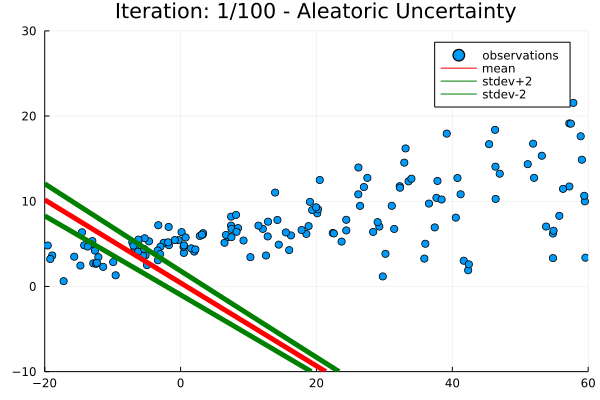

In [9]:
gif(anim2, fps=15)

In [10]:
# Save Figures
for iter in [1,2,3,100]
    mean = means[iter]
    stddev = stddevs[iter]
    fig = scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30))
    plot!(x_tst, mean, label="mean", linewidth=5, linecolor=:red, xlim=(-20,60), ylim=(-10, 30), title="Iteration: "*string(iter)*"/$epochs - Case 2 Aleatoric Uncertainty")
    plot!(x_tst, mean + 2 * stddev, linewidth=5, linecolor=:green, label="stdev+2", xlim=(-20,60), ylim=(-10, 30));
    plot!(x_tst, mean - 2 * stddev, linewidth=5, linecolor=:green, label="stdev-2", xlim=(-20,60), ylim=(-10, 30));
    savefig(fig, "images/case_2_frame_$iter.png")
end

In [11]:
model = create_nonlinear_model()
epochs = 100
losses, means, stddevs = train_model(model, train_loader, test_loader, epochs)
anim3 = @animate for iter in 1:epochs
    mean = means[iter]
    stddev = stddevs[iter]
    scatter(x_train, y_train, label="observations", xlim=(-20,60), ylim=(-10, 30))
    plot!(x_tst, mean, label="mean", linewidth=5, linecolor=:red, xlim=(-20,60), ylim=(-10, 30), title="Iteration: "*string(iter)*"/$epochs - Added Nonlinearity")
    plot!(x_tst, mean + 2 * stddev, linewidth=5, linecolor=:green, label="stdev+2", xlim=(-20,60), ylim=(-10, 30));
    plot!(x_tst, mean - 2 * stddev, linewidth=5, linecolor=:green, label="stdev-2", xlim=(-20,60), ylim=(-10, 30));
end

Animation("C:\\Users\\andre\\AppData\\Local\\Temp\\jl_64jNXt", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\andre\idea_projects\julia\CS5099\tmp.gif
└ @ Plots C:\Users\andre\.julia\packages\Plots\Ra8fG\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\andre\\idea_projects\\julia\\CS5099\\tmp.gif")
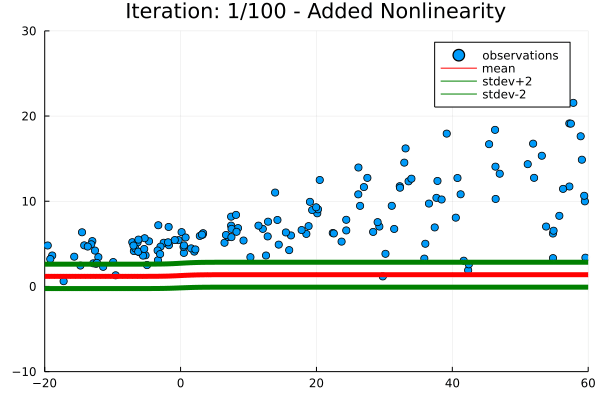

In [12]:
gif(anim3, fps=15)